In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import simpy
import numpy as np
from random import uniform, normalvariate, expovariate, seed, randint

from math import floor
from scipy import stats

import matplotlib.pyplot as mp
import seaborn
seaborn.set_theme(style="darkgrid")

In [3]:
def Average(list):            # progressive average
    temp = []
    for i in range(len(list)):
        temp.append(sum(list[0:i]) / (i+1))
    return temp

def QueueL(t=np.inf):         # Queue length at time (t)
    arr = set([int(Ă[k][1][9:]) for k in range(len(Ă)) if Ă[k][0] <= t])
    par = set([int(Ĵ[k][1][9:]) for k in range(len(Ĵ)) if Ĵ[k][0] <= t])
    return len(arr.difference(par))

def Arrival(s=0, t=np.inf):   # Arrivals in [s, t] interval
    temp = []
    for k in range(len(Ă)):
        if s <= int(Ă[k][0]) <= t:
               temp.append(int(Ă[k][1][9:]))
    return print('Number of patients arrived in [%d, %d] interval is: %d persons\nTheir ID:'%(s, t, len(temp)), temp)

def Partir(s=0, t=np.inf):    # Departures in [s, t] interval
    par = set([int(Ĵ[k][1][9:]) for k in range(len(Ĵ)) if s <= Ĵ[k][0] <= t])
    return sorted(list(par))

In [4]:
R_Seed = 4                              # Random Seed for Psuduo random generationseed
seed(R_Seed)                            # This helps scientific proccess for checking the results
Total_Beds = 10                         # Number of Available Beds in the Hospital's ICU
λ = 10                                  # Average arrival time [in days] for a patient, ...
                                        # ... so average arrival rate is 1/λ persons per day.
CT = 7                                  # Treatment Duration in days
min_Tol = uniform(0, 1)                 # Min. patients tolerance in days
Max_Tol = uniform(1, 2)                 # Max. patients tolerance in days
First_Batch = randint(1, 10)            # Initial number of patient in day 0.0
SIM_TIME = 365                          # Simulation time in days [integer]

Ă = []                                  # Arrivals (time, name)
Ň = []                                  # Throughput (time, 0|1)
Q = []                                  # Queue legth (persons)
B = []                                  # Server utilization [Busy] (Treatment Duration = CT)
W = []                                  # Waiting time (Success wait OR Failure wait)
Ĵ = []                                  # Exact time of leaving queue (ICU or dead)

def Patient(env, name, hp):             # Patients arrives, is served if possible and leaves (dead or alive).
    arrive = env.now
    Ă.append((arrive, name))
    print('Day%7.4f: %s Arrived at Medical Center ' %(arrive, name))
    with hp.Bed.request() as request:
        patience = uniform(min_Tol, Max_Tol)
        results = yield request | env.timeout(patience)
        waitS = env.now - arrive
        if request in results:          # Patient got to the IcuBed
            W.append(waitS)
            Ĵ.append((env.now, name))
            print('Day%7.4f: %s Waited for ICU Service %5.2f days & enters the ICU on day %5.2f' 
                  %(env.now, name, waitS, env.now))
            yield env.process(hp.Cure(name))
        else:                           # Patient couldn't get to the IcuBed and failed
            waitF = env.now - arrive
            Ĵ.append((env.now, name))
            Ň.append((env.now, 0))
            W.append(waitF)
            print('Day%7.4f: %s Passed away after %7.4f days' %(env.now, name, waitF))

class Hospital(object):
    def __init__(self, env, Beds, CureTime):
        self.env = env
        self.Bed = simpy.Resource(env, Beds)
        self.CureTime = CureTime

    def Cure(self, name):
        Bedridden = normalvariate(CT, CT/6)
        yield self.env.timeout(Bedridden)
        B.append(CT)
        Ň.append((env.now, 1))
        print("Day%7.4f: %s recived medical care for %7.4f days and discharged" 
              %(env.now, name, Bedridden))

def setup(env, beds, CureTime, landa):  # Create a Hospital, a number of initial patients and go on
    hp = Hospital(env, beds, CureTime)  # Creating the Hospital
    for i in range(First_Batch):        # Create initial patients:
        env.process(Patient(env, 'Patient #%d' %(i+1), hp))
    while True:                         # Keep creating more patients every ~λ days while the simulation is running
        yield env.timeout(expovariate(landa))
        i += 1
        env.process(Patient(env, 'Patient #%d' %(i+1), hp))

print('CoViD-19 Hospital', '\n')
env = simpy.Environment()
env.process(setup(env, Total_Beds, CT, λ))
env.run(until=SIM_TIME)

CoViD-19 Hospital 

Day 0.0000: Patient #1 Arrived at Medical Center 
Day 0.0000: Patient #2 Arrived at Medical Center 
Day 0.0000: Patient #3 Arrived at Medical Center 
Day 0.0000: Patient #4 Arrived at Medical Center 
Day 0.0000: Patient #5 Arrived at Medical Center 
Day 0.0000: Patient #6 Arrived at Medical Center 
Day 0.0000: Patient #7 Arrived at Medical Center 
Day 0.0000: Patient #1 Waited for ICU Service  0.00 days & enters the ICU on day  0.00
Day 0.0000: Patient #2 Waited for ICU Service  0.00 days & enters the ICU on day  0.00
Day 0.0000: Patient #3 Waited for ICU Service  0.00 days & enters the ICU on day  0.00
Day 0.0000: Patient #4 Waited for ICU Service  0.00 days & enters the ICU on day  0.00
Day 0.0000: Patient #5 Waited for ICU Service  0.00 days & enters the ICU on day  0.00
Day 0.0000: Patient #6 Waited for ICU Service  0.00 days & enters the ICU on day  0.00
Day 0.0000: Patient #7 Waited for ICU Service  0.00 days & enters the ICU on day  0.00
Day 0.0652: Patient #

Day28.2885: Patient #269 Passed away after  0.5485 days
Day28.2895: Patient #274 Arrived at Medical Center 
Day28.4267: Patient #275 Arrived at Medical Center 
Day28.4364: Patient #276 Arrived at Medical Center 
Day28.4568: Patient #268 Passed away after  0.7593 days
Day28.5815: Patient #272 Passed away after  0.4085 days
Day28.5823: Patient #273 Passed away after  0.4060 days
Day28.5955: Patient #274 Passed away after  0.3060 days
Day28.7485: Patient #277 Arrived at Medical Center 
Day28.8125: Patient #270 Passed away after  0.8232 days
Day28.8230: Patient #278 Arrived at Medical Center 
Day28.8970: Patient #279 Arrived at Medical Center 
Day28.9150: Patient #200 recived medical care for  7.8047 days and discharged
Day28.9150: Patient #271 Waited for ICU Service  0.90 days & enters the ICU on day 28.92
Day28.9155: Patient #280 Arrived at Medical Center 
Day28.9219: Patient #281 Arrived at Medical Center 
Day29.0408: Patient #277 Passed away after  0.2923 days
Day29.1232: Patient #276 

Day46.3153: Patient #445 Passed away after  1.0025 days
Day46.3641: Patient #453 Arrived at Medical Center 
Day46.3870: Patient #448 Passed away after  0.7246 days
Day46.4500: Patient #454 Arrived at Medical Center 
Day46.4689: Patient #382 recived medical care for  6.9752 days and discharged
Day46.4689: Patient #450 Waited for ICU Service  0.59 days & enters the ICU on day 46.47
Day46.5619: Patient #455 Arrived at Medical Center 
Day46.5692: Patient #456 Arrived at Medical Center 
Day46.6202: Patient #452 Passed away after  0.6154 days
Day46.6606: Patient #457 Arrived at Medical Center 
Day46.7348: Patient #458 Arrived at Medical Center 
Day46.8202: Patient #451 Passed away after  0.8680 days
Day47.0626: Patient #457 Passed away after  0.4020 days
Day47.0993: Patient #454 Passed away after  0.6493 days
Day47.3065: Patient #459 Arrived at Medical Center 
Day47.3827: Patient #460 Arrived at Medical Center 
Day47.3933: Patient #455 Passed away after  0.8314 days
Day47.4129: Patient #461 

Day69.1059: Patient #683 Arrived at Medical Center 
Day69.1296: Patient #678 Passed away after  0.3599 days
Day69.1940: Patient #677 Passed away after  0.4506 days
Day69.2733: Patient #684 Arrived at Medical Center 
Day69.3140: Patient #680 Passed away after  0.2927 days
Day69.3403: Patient #674 Passed away after  0.7418 days
Day69.3621: Patient #685 Arrived at Medical Center 
Day69.3909: Patient #683 Passed away after  0.2851 days
Day69.4286: Patient #682 Passed away after  0.3388 days
Day69.4478: Patient #675 Passed away after  0.8195 days
Day69.5853: Patient #586 recived medical care for  8.2224 days and discharged
Day69.5853: Patient #679 Waited for ICU Service  0.59 days & enters the ICU on day 69.59
Day69.6717: Patient #685 Passed away after  0.3095 days
Day69.6885: Patient #684 Passed away after  0.4152 days
Day69.6915: Patient #686 Arrived at Medical Center 
Day69.7082: Patient #687 Arrived at Medical Center 
Day69.7540: Patient #688 Arrived at Medical Center 
Day69.8244: Patie

Day92.0181: Patient #902 Passed away after  0.8434 days
Day92.0701: Patient #918 Arrived at Medical Center 
Day92.1338: Patient #919 Arrived at Medical Center 
Day92.2291: Patient #908 Passed away after  0.7976 days
Day92.3224: Patient #917 Passed away after  0.3128 days
Day92.3724: Patient #904 Passed away after  1.0958 days
Day92.3752: Patient #905 Passed away after  1.0950 days
Day92.3815: Patient #910 Passed away after  0.8267 days
Day92.4171: Patient #920 Arrived at Medical Center 
Day92.4652: Patient #855 recived medical care for  4.4597 days and discharged
Day92.4652: Patient #909 Waited for ICU Service  0.96 days & enters the ICU on day 92.47
Day92.5133: Patient #911 Passed away after  0.9468 days
Day92.5168: Patient #913 Passed away after  0.9288 days
Day92.6827: Patient #912 Passed away after  1.0948 days
Day92.6863: Patient #916 Passed away after  0.7111 days
Day92.8658: Patient #915 Passed away after  1.0451 days
Day92.8769: Patient #918 Passed away after  0.8068 days
Day92

Day107.4993: Patient #1066 Passed away after  0.7215 days
Day107.6654: Patient #1074 Arrived at Medical Center 
Day107.7009: Patient #1067 Passed away after  0.7682 days
Day107.7338: Patient #1075 Arrived at Medical Center 
Day107.8015: Patient #1076 Arrived at Medical Center 
Day107.8164: Patient #1073 Passed away after  0.3635 days
Day107.8471: Patient #1065 Passed away after  1.0984 days
Day107.8471: Patient #1077 Arrived at Medical Center 
Day107.9315: Patient #1078 Arrived at Medical Center 
Day108.0377: Patient #1071 Passed away after  0.8324 days
Day108.0878: Patient #1077 Passed away after  0.2407 days
Day108.1251: Patient #1072 Passed away after  0.7283 days
Day108.1756: Patient #1070 Passed away after  1.0979 days
Day108.1793: Patient #1076 Passed away after  0.3778 days
Day108.1976: Patient #1075 Passed away after  0.4638 days
Day108.2190: Patient #1079 Arrived at Medical Center 
Day108.2452: Patient #1080 Arrived at Medical Center 
Day108.2721: Patient #1081 Arrived at Medi

Day129.1389: Patient #1268 Passed away after  0.8893 days
Day129.1706: Patient #1279 Arrived at Medical Center 
Day129.2194: Patient #1183 recived medical care for  9.2351 days and discharged
Day129.2194: Patient #1269 Waited for ICU Service  0.88 days & enters the ICU on day 129.22
Day129.2734: Patient #1275 Passed away after  0.2610 days
Day129.2983: Patient #1280 Arrived at Medical Center 
Day129.3813: Patient #1281 Arrived at Medical Center 
Day129.4196: Patient #1282 Arrived at Medical Center 
Day129.4468: Patient #1283 Arrived at Medical Center 
Day129.4608: Patient #1279 Passed away after  0.2902 days
Day129.4895: Patient #1277 Passed away after  0.3813 days
Day129.5751: Patient #1280 Passed away after  0.2768 days
Day129.6196: Patient #1284 Arrived at Medical Center 
Day129.6504: Patient #1281 Passed away after  0.2691 days
Day129.6830: Patient #1285 Arrived at Medical Center 
Day129.6895: Patient #1274 Passed away after  0.7558 days
Day129.7173: Patient #1272 Passed away after

Day143.2498: Patient #1419 Passed away after  0.3234 days
Day143.2606: Patient #1355 recived medical care for  6.7769 days and discharged
Day143.2606: Patient #1413 Waited for ICU Service  0.88 days & enters the ICU on day 143.26
Day143.3219: Patient #1421 Arrived at Medical Center 
Day143.4528: Patient #1414 Passed away after  0.9237 days
Day143.4587: Patient #1422 Arrived at Medical Center 
Day143.5330: Patient #1415 Passed away after  0.9908 days
Day143.5366: Patient #1418 Passed away after  0.7821 days
Day143.5967: Patient #1423 Arrived at Medical Center 
Day143.6621: Patient #1424 Arrived at Medical Center 
Day143.6838: Patient #1367 recived medical care for  5.9824 days and discharged
Day143.6838: Patient #1420 Waited for ICU Service  0.70 days & enters the ICU on day 143.68
Day143.6869: Patient #1421 Passed away after  0.3649 days
Day143.7812: Patient #1425 Arrived at Medical Center 
Day143.8508: Patient #1426 Arrived at Medical Center 
Day143.8733: Patient #1427 Arrived at Medi

Day158.2296: Patient #1566 Arrived at Medical Center 
Day158.2491: Patient #1567 Arrived at Medical Center 
Day158.3244: Patient #1558 Passed away after  1.0148 days
Day158.3333: Patient #1568 Arrived at Medical Center 
Day158.3783: Patient #1569 Arrived at Medical Center 
Day158.3856: Patient #1480 recived medical care for  8.5625 days and discharged
Day158.3856: Patient #1562 Waited for ICU Service  0.76 days & enters the ICU on day 158.39
Day158.4055: Patient #1570 Arrived at Medical Center 
Day158.5656: Patient #1565 Passed away after  0.8495 days
Day158.5823: Patient #1571 Arrived at Medical Center 
Day158.6588: Patient #1572 Arrived at Medical Center 
Day158.6651: Patient #1564 Passed away after  0.9815 days
Day158.6712: Patient #1563 Passed away after  1.0205 days
Day158.8016: Patient #1566 Passed away after  0.5720 days
Day158.8961: Patient #1573 Arrived at Medical Center 
Day158.9143: Patient #1574 Arrived at Medical Center 
Day158.9276: Patient #1570 Passed away after  0.5222

Day174.2110: Patient #1641 recived medical care for  7.7855 days and discharged
Day174.2110: Patient #1713 Waited for ICU Service  0.50 days & enters the ICU on day 174.21
Day174.2411: Patient #1720 Arrived at Medical Center 
Day174.2637: Patient #1721 Arrived at Medical Center 
Day174.2645: Patient #1715 Passed away after  0.3642 days
Day174.2786: Patient #1722 Arrived at Medical Center 
Day174.3875: Patient #1654 recived medical care for  6.4184 days and discharged
Day174.3875: Patient #1714 Waited for ICU Service  0.59 days & enters the ICU on day 174.39
Day174.4798: Patient #1723 Arrived at Medical Center 
Day174.4841: Patient #1724 Arrived at Medical Center 
Day174.6542: Patient #1725 Arrived at Medical Center 
Day174.6651: Patient #1726 Arrived at Medical Center 
Day174.6810: Patient #1727 Arrived at Medical Center 
Day174.7149: Patient #1728 Arrived at Medical Center 
Day174.8268: Patient #1724 Passed away after  0.3427 days
Day174.8361: Patient #1717 Passed away after  0.7459 d

Day190.4004: Patient #1871 Passed away after  0.7645 days
Day190.4212: Patient #1873 Passed away after  0.7261 days
Day190.4468: Patient #1880 Arrived at Medical Center 
Day190.4798: Patient #1881 Arrived at Medical Center 
Day190.5233: Patient #1868 Passed away after  1.0608 days
Day190.5732: Patient #1870 Passed away after  0.9867 days
Day190.7288: Patient #1872 Passed away after  1.0921 days
Day190.7470: Patient #1882 Arrived at Medical Center 
Day190.8035: Patient #1876 Passed away after  0.7236 days
Day190.8053: Patient #1883 Arrived at Medical Center 
Day190.8811: Patient #1877 Passed away after  0.6855 days
Day190.9314: Patient #1880 Passed away after  0.4846 days
Day191.1336: Patient #1884 Arrived at Medical Center 
Day191.1455: Patient #1879 Passed away after  0.7981 days
Day191.1772: Patient #1885 Arrived at Medical Center 
Day191.2206: Patient #1886 Arrived at Medical Center 
Day191.2218: Patient #1878 Passed away after  0.9963 days
Day191.2840: Patient #1887 Arrived at Medi

Day219.4743: Patient #2165 Arrived at Medical Center 
Day219.5196: Patient #2166 Arrived at Medical Center 
Day219.5589: Patient #2157 Passed away after  0.5163 days
Day219.5824: Patient #2167 Arrived at Medical Center 
Day219.5911: Patient #2168 Arrived at Medical Center 
Day219.5926: Patient #2161 Passed away after  0.3364 days
Day219.7536: Patient #2169 Arrived at Medical Center 
Day219.7562: Patient #2165 Passed away after  0.2819 days
Day219.7800: Patient #2164 Passed away after  0.3218 days
Day219.7801: Patient #2154 Passed away after  1.0400 days
Day219.7906: Patient #2065 recived medical care for  8.7299 days and discharged
Day219.7906: Patient #2156 Waited for ICU Service  0.81 days & enters the ICU on day 219.79
Day219.8655: Patient #2166 Passed away after  0.3459 days
Day219.8668: Patient #2163 Passed away after  0.5326 days
Day219.8738: Patient #2170 Arrived at Medical Center 
Day219.8975: Patient #2081 recived medical care for  7.7197 days and discharged
Day219.8975: Patie

Day235.5942: Patient #2312 Arrived at Medical Center 
Day235.6968: Patient #2313 Arrived at Medical Center 
Day235.7280: Patient #2314 Arrived at Medical Center 
Day235.7947: Patient #2315 Arrived at Medical Center 
Day235.8247: Patient #2229 recived medical care for  8.3184 days and discharged
Day235.8247: Patient #2308 Waited for ICU Service  0.89 days & enters the ICU on day 235.82
Day235.8566: Patient #2311 Passed away after  0.3609 days
Day235.8783: Patient #2316 Arrived at Medical Center 
Day236.0528: Patient #2315 Passed away after  0.2581 days
Day236.0626: Patient #2312 Passed away after  0.4684 days
Day236.1151: Patient #2314 Passed away after  0.3871 days
Day236.1865: Patient #2317 Arrived at Medical Center 
Day236.2710: Patient #2318 Arrived at Medical Center 
Day236.2922: Patient #2310 Passed away after  0.8455 days
Day236.3757: Patient #2319 Arrived at Medical Center 
Day236.3966: Patient #2316 Passed away after  0.5184 days
Day236.4108: Patient #2241 recived medical care 

Day259.5824: Patient #2547 Arrived at Medical Center 
Day259.6107: Patient #2548 Arrived at Medical Center 
Day259.6878: Patient #2549 Arrived at Medical Center 
Day259.6890: Patient #2541 Passed away after  0.6869 days
Day259.7573: Patient #2542 Passed away after  0.6579 days
Day259.7643: Patient #2471 recived medical care for  6.9803 days and discharged
Day259.7643: Patient #2543 Waited for ICU Service  0.65 days & enters the ICU on day 259.76
Day259.7853: Patient #2550 Arrived at Medical Center 
Day259.7890: Patient #2544 Passed away after  0.5786 days
Day260.0209: Patient #2545 Passed away after  0.5436 days
Day260.1486: Patient #2495 recived medical care for  5.8829 days and discharged
Day260.1486: Patient #2546 Waited for ICU Service  0.64 days & enters the ICU on day 260.15
Day260.2737: Patient #2551 Arrived at Medical Center 
Day260.4482: Patient #2552 Arrived at Medical Center 
Day260.4591: Patient #2550 Passed away after  0.6738 days
Day260.5261: Patient #2553 Arrived at Medi

Day277.6502: Patient #2731 Arrived at Medical Center 
Day277.6993: Patient #2732 Arrived at Medical Center 
Day277.7046: Patient #2724 Passed away after  0.7440 days
Day277.7711: Patient #2723 Passed away after  1.0652 days
Day277.7856: Patient #2733 Arrived at Medical Center 
Day277.8066: Patient #2726 Passed away after  0.7386 days
Day277.8280: Patient #2728 Passed away after  0.2930 days
Day277.9025: Patient #2734 Arrived at Medical Center 
Day277.9062: Patient #2735 Arrived at Medical Center 
Day277.9868: Patient #2736 Arrived at Medical Center 
Day278.0026: Patient #2737 Arrived at Medical Center 
Day278.0615: Patient #2654 recived medical care for  6.5648 days and discharged
Day278.0615: Patient #2727 Waited for ICU Service  0.81 days & enters the ICU on day 278.06
Day278.0698: Patient #2738 Arrived at Medical Center 
Day278.0858: Patient #2732 Passed away after  0.3864 days
Day278.1920: Patient #2739 Arrived at Medical Center 
Day278.2457: Patient #2740 Arrived at Medical Center

Day292.9777: Patient #2882 Arrived at Medical Center 
Day293.0181: Patient #2883 Arrived at Medical Center 
Day293.0243: Patient #2884 Arrived at Medical Center 
Day293.0838: Patient #2876 Passed away after  0.6795 days
Day293.2136: Patient #2880 Passed away after  0.4588 days
Day293.3009: Patient #2885 Arrived at Medical Center 
Day293.3124: Patient #2817 recived medical care for  7.4283 days and discharged
Day293.3124: Patient #2877 Waited for ICU Service  0.78 days & enters the ICU on day 293.31
Day293.3281: Patient #2886 Arrived at Medical Center 
Day293.3665: Patient #2887 Arrived at Medical Center 
Day293.3990: Patient #2882 Passed away after  0.4214 days
Day293.4076: Patient #2888 Arrived at Medical Center 
Day293.4635: Patient #2889 Arrived at Medical Center 
Day293.4874: Patient #2890 Arrived at Medical Center 
Day293.5682: Patient #2881 Passed away after  0.6533 days
Day293.6124: Patient #2891 Arrived at Medical Center 
Day293.6139: Patient #2878 Passed away after  1.0733 day

Day305.3817: Patient #3016 Passed away after  0.5300 days
Day305.4177: Patient #3013 Passed away after  0.7404 days
Day305.4553: Patient #3020 Arrived at Medical Center 
Day305.4772: Patient #3021 Arrived at Medical Center 
Day305.5177: Patient #3011 Passed away after  1.0128 days
Day305.6523: Patient #3014 Passed away after  0.8808 days
Day305.7113: Patient #3022 Arrived at Medical Center 
Day305.8068: Patient #3023 Arrived at Medical Center 
Day305.8113: Patient #3024 Arrived at Medical Center 
Day305.8510: Patient #3021 Passed away after  0.3738 days
Day305.8577: Patient #3018 Passed away after  0.6521 days
Day305.8632: Patient #3015 Passed away after  1.0200 days
Day305.9077: Patient #3025 Arrived at Medical Center 
Day305.9897: Patient #3017 Passed away after  0.8591 days
Day306.0390: Patient #3026 Arrived at Medical Center 
Day306.1085: Patient #3027 Arrived at Medical Center 
Day306.1320: Patient #3028 Arrived at Medical Center 
Day306.1640: Patient #3019 Passed away after  0.85

Day328.7980: Patient #3249 Arrived at Medical Center 
Day328.8703: Patient #3244 Passed away after  0.2945 days
Day328.8775: Patient #3250 Arrived at Medical Center 
Day328.8907: Patient #3251 Arrived at Medical Center 
Day328.8909: Patient #3240 Passed away after  0.5345 days
Day328.9115: Patient #3246 Passed away after  0.2837 days
Day328.9366: Patient #3237 Passed away after  0.8494 days
Day328.9444: Patient #3252 Arrived at Medical Center 
Day328.9904: Patient #3253 Arrived at Medical Center 
Day329.0918: Patient #3254 Arrived at Medical Center 
Day329.1957: Patient #3241 Passed away after  0.8148 days
Day329.2079: Patient #3255 Arrived at Medical Center 
Day329.2674: Patient #3256 Arrived at Medical Center 
Day329.2699: Patient #3239 Passed away after  0.9395 days
Day329.2789: Patient #3257 Arrived at Medical Center 
Day329.3927: Patient #3243 Passed away after  0.9138 days
Day329.4113: Patient #3258 Arrived at Medical Center 
Day329.4220: Patient #3247 Passed away after  0.6841 d

Day344.2535: Patient #3413 Passed away after  0.4451 days
Day344.2554: Patient #3411 Passed away after  0.4981 days
Day344.2760: Patient #3410 Passed away after  0.5552 days
Day344.2926: Patient #3417 Arrived at Medical Center 
Day344.3471: Patient #3418 Arrived at Medical Center 
Day344.3780: Patient #3419 Arrived at Medical Center 
Day344.4096: Patient #3420 Arrived at Medical Center 
Day344.4432: Patient #3416 Passed away after  0.5075 days
Day344.5415: Patient #3421 Arrived at Medical Center 
Day344.5499: Patient #3422 Arrived at Medical Center 
Day344.5680: Patient #3415 Passed away after  0.6743 days
Day344.5702: Patient #3423 Arrived at Medical Center 
Day344.6260: Patient #3424 Arrived at Medical Center 
Day344.6629: Patient #3418 Passed away after  0.3158 days
Day344.6779: Patient #3417 Passed away after  0.3853 days
Day344.7002: Patient #3425 Arrived at Medical Center 
Day344.7150: Patient #3414 Passed away after  0.8755 days
Day344.7270: Patient #3320 recived medical care fo

Day362.3725: Patient #3566 Passed away after  0.2525 days
Day362.4005: Patient #3571 Arrived at Medical Center 
Day362.4232: Patient #3572 Arrived at Medical Center 
Day362.4652: Patient #3573 Arrived at Medical Center 
Day362.5232: Patient #3574 Arrived at Medical Center 
Day362.5438: Patient #3493 recived medical care for  7.7299 days and discharged
Day362.5438: Patient #3562 Waited for ICU Service  0.69 days & enters the ICU on day 362.54
Day362.5705: Patient #3575 Arrived at Medical Center 
Day362.6670: Patient #3576 Arrived at Medical Center 
Day362.6911: Patient #3577 Arrived at Medical Center 
Day362.7267: Patient #3578 Arrived at Medical Center 
Day362.8136: Patient #3579 Arrived at Medical Center 
Day362.8554: Patient #3575 Passed away after  0.2849 days
Day362.8609: Patient #3571 Passed away after  0.4604 days
Day362.9023: Patient #3568 Passed away after  0.6726 days
Day362.9474: Patient #3580 Arrived at Medical Center 
Day362.9795: Patient #3567 Passed away after  0.7769 day

In [5]:
print ('Last patient is:', Ă[-1][1])

Last patient is: Patient #3600


# Arrivals:

In [6]:
Arrival(99, 100)

Number of patients arrived in [99, 100] interval is: 21 persons
Their ID: [991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011]


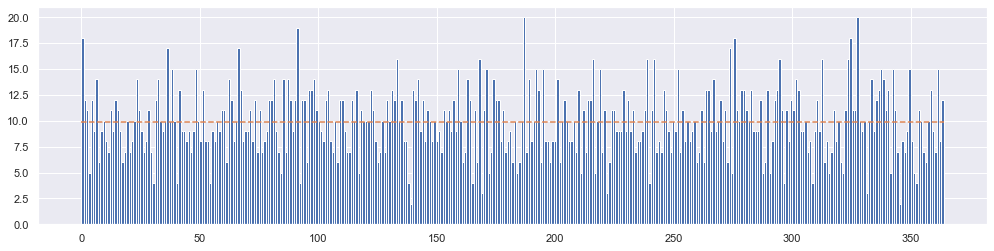

In [7]:
A_ = [] 
for a in Ă:
    A_.append(floor(a[0]))

mp.figure(figsize=(17,4))
a1, a2, a3 = mp.hist(A_, int(SIM_TIME))
mp.plot(range(SIM_TIME), np.ones(SIM_TIME)*np.average(a1), '--')
mp.show()

In [8]:
A_[-11:]

[364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364]

In [9]:
print('Average of Arrivals: Ā = %.2f patients per day' %np.average(a1))

Average of Arrivals: Ā = 9.86 patients per day


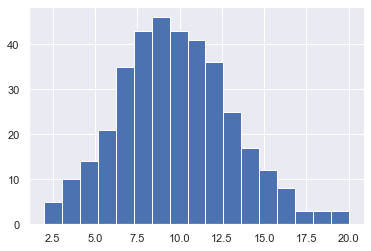

X ~ N(9.86, 3.20)


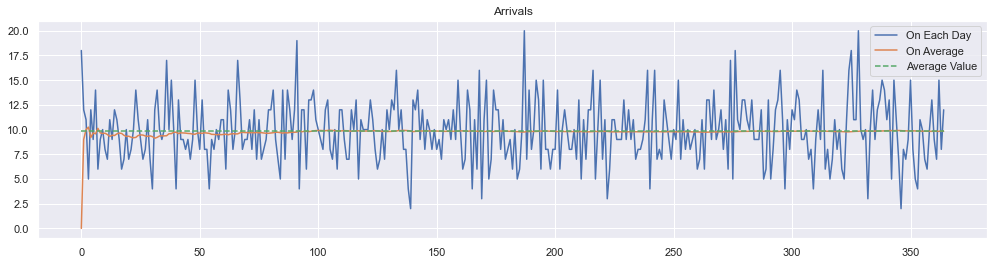

In [10]:
List = a1
X = range(len(List))
Y = List
mp.figure(figsize=(6,4))
Δ = max(List) - min(List)
μ, σ = stats.norm.fit(Y)
mp.hist(Y, 17)
mp.show()
print("X ~ N(%.2f, %.2f)" %(μ, σ))
mp.figure(figsize=(17,4))
mp.title("Arrivals")
mp.plot(X, Y, label='On Each Day')
mp.plot(X, Average(Y), label='On Average')
mp.plot(X, np.ones(len(List))*np.average(Y), '--', label = 'Average Value')
mp.legend();

# Throughput 
(Proccessed units per unit of time)

In [11]:
N = []
for k in range(len(Ň)):
    N.append(Ň[k][1])

print('Total: %.2f Persons on each day\nSuaccess: %.2f  Persons on each day\nFailure: %.2f Persons on each day' 
      %((N.count(1) + N.count(0)) / SIM_TIME, N.count(1) / SIM_TIME, N.count(0) / SIM_TIME))

Total: 9.81 Persons on each day
Suaccess: 1.40  Persons on each day
Failure: 8.41 Persons on each day


In [12]:
N_ = sum(N) / len(Ĵ)
print('Over All\nSuccess Rate: N̄ = %.2f%%' %(100*N_))

Over All
Success Rate: N̄ = 14.26%


Succes= 14.30%
Failure= 85.70%


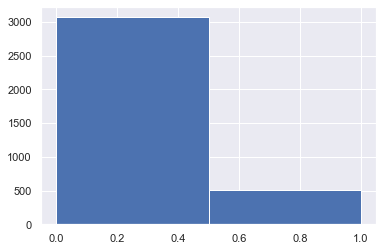

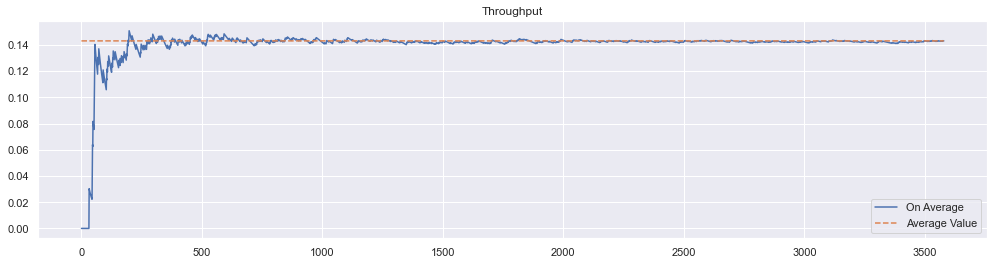

In [13]:
List = N
X = range(len(List))
Y = List
mp.figure(figsize=(6,4))
N1, N2, N3 = mp.hist(List, 2)
print("Succes= %.02f%%\nFailure= %.2f%%" %(100*N1[1] / (N1[0]+N1[1]), 100*N1[0] / (N1[0]+N1[1]) ) )
mp.show()

mp.figure(figsize=(17,4))
mp.title("Throughput")
# mp.plot(range(len(List)), List, '.', label='On Each Day')
mp.plot(X, Average(Y), label='On Average')
mp.plot(X, np.ones(len(X))*np.average(Y), '--', label = 'Average Value')
mp.legend();

# Jobs Done

In [14]:
print('Total jobs Done: %d personns (dead or alive)' %len(Ĵ))

Total jobs Done: 3590 personns (dead or alive)


In [15]:
print('Unfinished Businesses: %d jobs' %(len(Ă) - len(Ĵ)))

Unfinished Businesses: 10 jobs


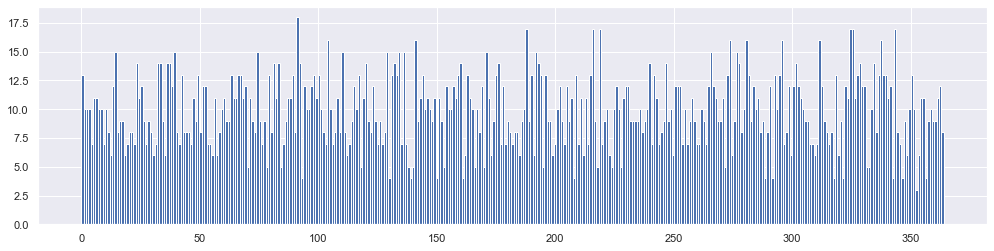

In [16]:
J = []
X = range(SIM_TIME)
for k in range(len(Ĵ)):
    J.append(floor(Ĵ[k][0]))

mp.figure(figsize=(17,4))    
j1, j2, j3 = mp.hist(J, int(SIM_TIME))
J_ = np.average(j1)

In [17]:
print('Average of Jobs done: J̄ = %.2f patients per day' %J_)

Average of Jobs done: J̄ = 9.84 patients per day


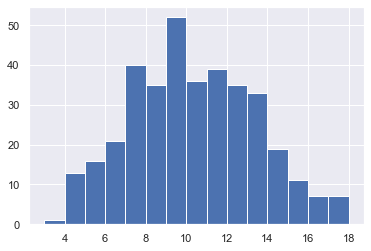

Jobs Done on each day ~ N(9.84, 3.08)


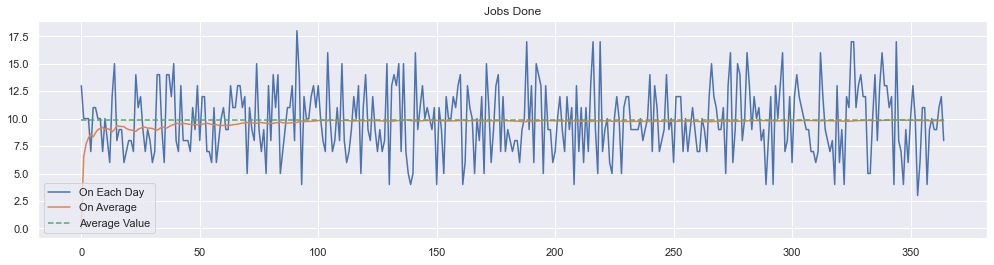

In [18]:
List = j1
X = range(len(List))
Y = List

mp.figure(figsize=(6,4))
Δ = int(max(List) - min(List))
μ, σ = stats.norm.fit(List)
mp.hist(List, Δ)
mp.show()
print("Jobs Done on each day ~ N(%.2f, %.2f)" %(μ, σ))

mp.figure(figsize=(17,4))
mp.title("Jobs Done")
mp.plot(range(len(List)), List, label='On Each Day')
mp.plot(range(len(List)), Average(List), label='On Average')
mp.plot(X, np.ones(len(List))*np.average(Y), '--', label = 'Average Value')
mp.legend();

# Queue Length

In [19]:
QL = [QueueL(d) for d in range(SIM_TIME)]
Q_ = np.average(QL)
print('Average queue length: Q̄ = %.1f persons' %Q_)

Average queue length: Q̄ = 6.4 persons


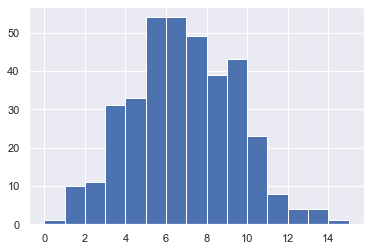

X ~ N(6.37, 2.59)


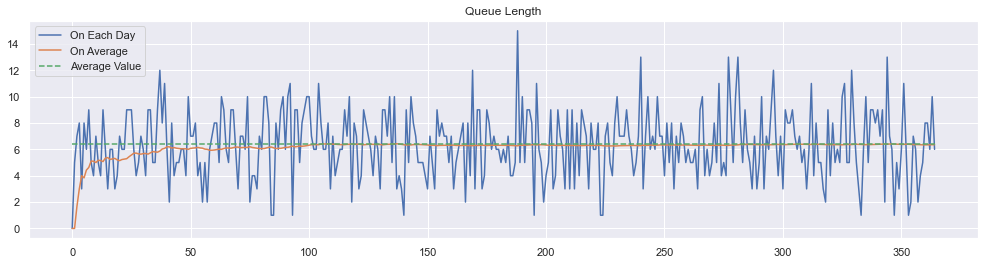

In [20]:
List = QL
X = range(len(List))
Y = List

mp.figure(figsize=(6,4))
Δ = max(List) - min(List)
μ, σ = stats.norm.fit(List)
mp.hist(List, Δ)
mp.show()
print("X ~ N(%.2f, %.2f)" %(μ, σ))

mp.figure(figsize=(17,4))
mp.title("Queue Length")
mp.plot(range(len(List)), List, label='On Each Day')
mp.plot(range(len(List)), Average(List), label='On Average')
mp.plot(X, np.ones(len(List))*np.average(Y), '--', label = 'Average Value')
mp.legend();

# Server Utilization

In [21]:
B_ = sum(B) / (Total_Beds*SIM_TIME)
print('Average server utilization: B̄ = %.2f%%' %(100*B_))

Average server utilization: B̄ = 98.19%


# Waiting Time

In [22]:
W_ = sum(W) / len(W)
print('Average time spent by individuals in queue: W̄ = %5.2f days' %W_)

Average time spent by individuals in queue: W̄ =  0.64 days


In [23]:
print ('Last 10 patients departed system (dead or alive): ', Partir(0, 365)[-10:])

Last 10 patients departed system (dead or alive):  [3581, 3582, 3583, 3584, 3585, 3586, 3587, 3588, 3589, 3591]
